# <center>Fully Connected Neural Network</center>

In this assignment, you will learn how to build a fully connected neural network using NumPy. Note that you **cannot** use Pytorch for this assignment.

## 1 -  Neural network architecture
You will build a fully connected neural network with 4 layers: an input layer, two hidden layers, and an output layer. Each layer will be fully connected, and the network will use the sigmoid activation function. Optimization will be done using stochastic gradient descent.

Let's define the layers in detail. Since the task is to classify digits, the neural network will output probabilities indicating how likely an input image belongs to each class.

1. **Input Layer**: The input consists of 28x28 pixel images. These images will be flattened into a one-dimensional array of size $ 28 \times 28 = 784 $ elements. Therefore, the input layer will have 784 nodes.
   
2. **1st Hidden Layer**: This layer will reduce the number of nodes from 784 (in the input layer) to 64. The goal here is to learn a compact representation of the input features.

3. **2nd Hidden Layer**: This layer will reduce the number of nodes from 64 (in the 1st Hidden Layer) to 32. The goal here is to learn a compact representation of the input features.
   
4. **Output Layer**: The 2nd hidden layer’s 32 nodes will be further reduced to 10 nodes in the output layer. This corresponds to the 10 possible digit classes (0 through 9). The output will be an array of 10 elements, where each element represents the probability that the input image belongs to that class. The correct class will have a label of 1, while all others will be labeled 0.


In [ ]:
import numpy as np
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt
import time

## 2 - Helper functions

In [ ]:
# Helper function
def show_images(image, num_row=2, num_col=5):
    # plot images
    image_size = int(np.sqrt(image.shape[-1]))
    image = np.reshape(image, (image.shape[0], image_size, image_size))
    fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
    for i in range(num_row*num_col):
        ax = axes[i//num_col, i%num_col]
        ax.imshow(image[i], cmap='gray', vmin=0, vmax=1)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

def one_hot(x, k, dtype=np.float32):
    """Create a one-hot encoding of x of size k."""
    return np.array(x[:, None] == np.arange(k), dtype)

## 3 - Dataset preparation
In this assignment, you will use the [MNIST dataset](http://yann.lecun.com/exdb/mnist/) to demonstrate how to build a neural network. The MNIST dataset contains 70,000 grayscale images of handwritten digits, with 60,000 used for training and 10,000 for testing. Each image is \(28 x 28\) pixels, and the pixel values range from 0 to 255.

### Note
To load the dataset, `fetch_openml` requires `scikit-learn >= 0.22`. If you are using an older version, replace `from sklearn.datasets import fetch_openml` with `from sklearn.datasets import fetch_mldata`.

Next, we will load and preprocess the dataset so it can be used in NumPy. The images will be normalized by dividing all pixel values by 255, which scales the data to a range between 0 and 1. This helps avoid numerical stability issues with activation functions. Additionally, we will use one-hot encoding for the labels, which makes it easier to compute the error between the network's output and the true labels. Lastly, we will flatten each image into an array of \(28 x 28 = 784\) elements to match the input layer's requirements.

In [ ]:
# Load data
mnist_data = fetch_openml("mnist_784")
x = mnist_data["data"]
y = mnist_data["target"].astype(int)

# Normalize
x /= 255.0

# One-hot encode labels
num_labels = 10
examples = y.shape[0]
y_new = one_hot(np.array(y), num_labels)

# Split, reshape, shuffle
train_size = 60000
test_size = x.shape[0] - train_size
x_train, x_test = x[:train_size].to_numpy(), x[train_size:].to_numpy()
y_train, y_test = y_new[:train_size], y_new[train_size:]

shuffle_index = np.random.permutation(train_size)
x_train, y_train = x_train[shuffle_index], y_train[shuffle_index]

Training data: (60000, 784) (60000, 10)
Test data: (10000, 784) (10000, 10)


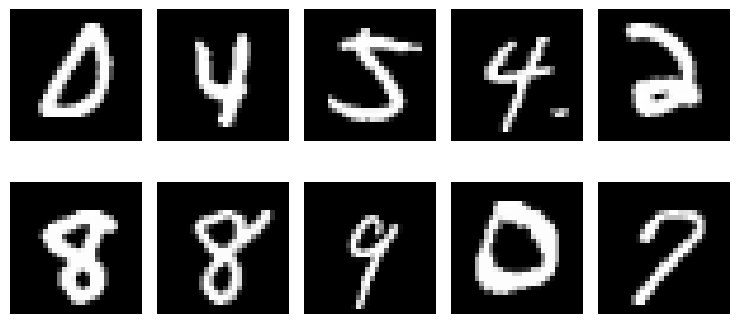

In [ ]:
print("Training data: {} {}".format(x_train.shape, y_train.shape))
print("Test data: {} {}".format(x_test.shape, y_test.shape))
show_images(x_train)

## 4 - Fully Connected Neural Network with Numpy


### Initialization
The neural network transforms data from 784 input nodes down to 10 output nodes. This transformation is achieved by defining the number of nodes in each layer through an array of sizes passed when initializing the `DeepNeuralNetwork` class. For instance, specifying `[784, 64, 32, 10]` would create a network with an input layer of 784 nodes, a hidden layer of 64 nodes, a hidden layer of 32 nodes, and an output layer of 10 nodes.

To optimize the network’s performance, it’s crucial to initialize weights carefully. A common approach is to scale the weights’ variance in each layer to stabilize learning. Following a technique recommended by Andrew Ng, we set the variance for each layer's weights to $\frac{1}{n} $, where $n$ is the number of nodes feeding into that layer. To achieve this, we initialize weights using values from a standard normal distribution, then scale by $\frac{1}{\sqrt{n}}$, where $n$ is the number of inputs to the layer.

Weight initialization can be complex, especially because it requires an understanding of linear algebra to grasp how dimensions interact in dot products. This is beyond the current scope, but this approach helps in stabilizing the forward pass and ultimately contributes to more effective training of the neural network.

### Feedforward
The forward pass in this neural network primarily involves matrix multiplication, which in NumPy is performed with the dot operation. In detail, we multiply the weights by the activations of the previous layer and then apply the sigmoid activation function to the result.

To propagate through each layer, we sequentially apply the dot operation, followed by the sigmoid activation function. In the final layer, we use the softmax function to generate probabilities for each class, allowing us to measure how well our current forward pass performs by comparing the predicted probabilities with the true class labels.


### Backpropagation

In this task, you'll implement backpropagation to update the weights and biases of a neural network based on the gradients of the loss function.

1. **Calculate Output Layer Gradients**: Compute the error for the output layer by taking the difference between the network’s predictions and the actual labels. Use this to calculate the weight and bias gradients for the output layer.

2. **Backpropagate to Hidden Layers**: Propagate the error from the output layer back to the hidden layer. This involves multiplying the output layer’s gradients by the weights of that layer, then adjusting for the activation function’s derivative.

3. **Store and Return Gradients**: Organize the computed gradients for each layer’s weights and biases, so they’re ready for use in the parameter update step.

This process should result in a dictionary of gradients for efficient optimization.

### Training (Stochastic Gradient Descent)
To train our neural network, we need a training loop that combines the forward and backward passes with an optimization step. Here, we’ll use Stochastic Gradient Descent (SGD) as the optimizer to update the network’s parameters.

The training function consists of two main loops:

1. **Epoch Loop**: This outer loop iterates through the dataset a set number of times (epochs).
2. **Batch Loop**: For each epoch, this inner loop processes each batch of data individually.

For each batch, the process includes:

- **Forward Pass**: Call `self.feed_forward()` with `x`, a batch of input data (flattened into an array of length 784). The function returns `output`, the network's prediction.
- **Backward Pass**: Using the `output` from the forward pass and the one-hot encoded ground truth labels `y`, the backward pass (`self.back_propagate()`) calculates the gradients for the weights.
- **Optimization with SGD**: The `optimize()` function then updates the parameters based on the gradients using SGD, which adjusts each parameter directly in the direction of the calculated gradient.

After each epoch, we can assess the network’s performance by calculating accuracy on a validation set. This provides a check on how well the model generalizes beyond the training data.

In [ ]:
class DeepNeuralNetwork():
    def __init__(self, sizes):
        self.sizes = sizes

        self.activation = self.sigmoid

        # Initialize all the weights and biases
        self.params = self.initialize()
        # Save all intermediate values, i.e. activations
        self.cache = {}

    def sigmoid(self, x, derivative=False):

        if derivative:
            ### START CODE HERE ### (≈ 1 line of code)
            # Calculate the derivative of the sigmoid function
            return x * (1 - x)

            ### END CODE HERE ###

        ### START CODE HERE ### (≈ 1 line of code)
        # Implement the forward pass of the sigmoid function

        return 1 / (1 + np.exp(-x))

        ### END CODE HERE ###

    def softmax(self, x):

        ### START CODE HERE ###
        # Calculate softmax loss function
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_x / exp_x.sum(axis=1, keepdims=True)


        ### END CODE HERE ###

    def initialize(self):
        # number of nodes in each layer
        input_layer=self.sizes[0]
        hidden_layer_1=self.sizes[1]
        hidden_layer_2=self.sizes[2]
        output_layer=self.sizes[3]

        params = {
            "W1": np.random.randn(hidden_layer_1, input_layer) * np.sqrt(1./input_layer),
            "b1": np.zeros((hidden_layer_1, 1)),
            "W2": np.random.randn(hidden_layer_2, hidden_layer_1) * np.sqrt(1./hidden_layer_1),
            "b2": np.zeros((hidden_layer_2, 1)),
            "W3": np.random.randn(output_layer, hidden_layer_2) * np.sqrt(1./hidden_layer_2),
            "b3": np.zeros((output_layer, 1))
        }
        return params

    def feed_forward(self, x):

        self.cache["X"] = x
        ### START CODE HERE ###
        # Implement forward pass for each layer

        self.cache["Z1"] = np.dot(x, self.params["W1"].T) + self.params["b1"].T
        self.cache["A1"] = self.sigmoid(self.cache["Z1"])
        self.cache["Z2"] = np.dot(self.cache["A1"], self.params["W2"].T) + self.params["b2"].T
        self.cache["A2"] = self.sigmoid(self.cache["Z2"])
        self.cache["Z3"] = np.dot(self.cache["A2"], self.params["W3"].T) + self.params["b3"].T
        self.cache["A3"] = self.softmax(self.cache["Z3"])

        ### END CODE HERE ###

        return self.cache["A3"]

    def back_propagate(self, y, output):

        current_batch_size = y.shape[0]

        ### START CODE HERE ###
        # Calculate gradients for each layer's weights and biases

        dZ3 = output - y
        dW3 = np.dot(dZ3.T, self.cache["A2"]) / current_batch_size
        db3 = dZ3.sum(axis=0).reshape(-1, 1) / current_batch_size

        dA2 = np.dot(dZ3, self.params["W3"])
        dZ2 = dA2 * self.sigmoid(self.cache["A2"], derivative=True)
        dW2 = np.dot(dZ2.T, self.cache["A1"]) / current_batch_size
        db2 = dZ2.sum(axis=0).reshape(-1, 1) / current_batch_size

        dA1 = np.dot(dZ2, self.params["W2"])
        dZ1 = dA1 * self.sigmoid(self.cache["A1"], derivative=True)
        dW1 = np.dot(dZ1.T, self.cache["X"]) / current_batch_size
        db1 = dZ1.sum(axis=0).reshape(-1, 1) / current_batch_size

        ### END CODE HERE ###

        self.grads = {"W1": dW1, "b1": db1, "W2": dW2, "b2": db2, "W3": dW3, "b3": db3}
        return self.grads

    def cross_entropy_loss(self, y, output):

        ### START CODE HERE ###
        # Compute cross-entropy loss
        return -np.sum(y * np.log(output)) / y.shape[0]

        ### END CODE HERE ###

    def optimize(self, l_rate=0.1):
        ### START CODE HERE ### (≈ 3 lines of code)
        # Update each parameter using the calculated gradients in self.grads
        for param in self.params.keys():
            self.params[param] -= l_rate * self.grads[param]

        ### END CODE HERE ###

    def accuracy(self, y, output):
        ### START CODE HERE ###
        # Calculate accuracy by comparing predictions to true labels
        predictions = np.argmax(output, axis=1)
        labels = np.argmax(y, axis=1)
        return np.mean(predictions == labels)

        ### END CODE HERE ###

    def train(self, x_train, y_train, x_test, y_test, epochs=10,
              batch_size=64, l_rate=0.1):
        # Hyperparameters
        self.epochs = epochs
        self.batch_size = batch_size
        num_batches = (x_train.shape[0] // self.batch_size)

        start_time = time.time()
        template = "Epoch {}: {:.2f}s, train acc={:.2f}, train loss={:.2f}, test acc={:.2f}, test loss={:.2f}"

        # Train
        for i in range(self.epochs):
            # Shuffle
            permutation = np.random.permutation(x_train.shape[0])
            x_train_shuffled = x_train[permutation]
            y_train_shuffled = y_train[permutation]

            for j in range(num_batches):
                # Batch
                begin = j * self.batch_size
                end = min(begin + self.batch_size, x_train.shape[0]-1)
                x = x_train_shuffled[begin:end]
                y = y_train_shuffled[begin:end]

                ### START CODE HERE ### (≈ 3 lines of code)
                # Implement forward pass, backpropagation, and optimization
                # Implement forward pass
                output = self.feed_forward(x)

                # Backpropagation
                self.back_propagate(y, output)

                # Optimization
                self.optimize(l_rate)


                ### END CODE HERE ###


            # Evaluate performance
            # Training data
            output = self.feed_forward(x_train)
            train_acc = self.accuracy(y_train, output)
            train_loss = self.cross_entropy_loss(y_train, output)
            # Test data
            output = self.feed_forward(x_test)
            test_acc = self.accuracy(y_test, output)
            test_loss = self.cross_entropy_loss(y_test, output)
            print(template.format(i+1, time.time()-start_time, train_acc, train_loss, test_acc, test_loss))

### Results

In [ ]:
dnn = DeepNeuralNetwork(sizes=[784, 64, 32, 10])
dnn.train(x_train, y_train, x_test, y_test, batch_size=128, l_rate=4)

Epoch 1: 3.33s, train acc=0.94, train loss=0.20, test acc=0.94, test loss=0.21
Epoch 2: 5.25s, train acc=0.97, train loss=0.11, test acc=0.96, test loss=0.13
Epoch 3: 7.03s, train acc=0.98, train loss=0.08, test acc=0.97, test loss=0.11
Epoch 4: 8.85s, train acc=0.98, train loss=0.07, test acc=0.97, test loss=0.10
Epoch 5: 10.88s, train acc=0.98, train loss=0.06, test acc=0.97, test loss=0.10
Epoch 6: 14.46s, train acc=0.98, train loss=0.05, test acc=0.97, test loss=0.09
Epoch 7: 18.12s, train acc=0.98, train loss=0.06, test acc=0.97, test loss=0.10
Epoch 8: 21.85s, train acc=0.99, train loss=0.04, test acc=0.97, test loss=0.09
Epoch 9: 25.26s, train acc=0.99, train loss=0.03, test acc=0.98, test loss=0.08
Epoch 10: 28.89s, train acc=0.99, train loss=0.03, test acc=0.97, test loss=0.08
